### Setup

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
# Check if Cuda is running
#torch.cuda.get_device_name(0)

In [4]:
data = pd.read_csv("creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [5]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
230513,146360.0,-0.208103,0.969149,0.177749,-0.636113,0.372358,-1.085819,0.935908,-0.142743,0.221779,...,-0.291806,-0.611120,0.088831,-0.036603,-0.470064,0.149911,0.356194,0.156509,3.58,0
244122,152215.0,-0.381810,0.793184,-1.643861,-0.594889,3.970920,3.061948,0.804784,0.634344,-1.086486,...,0.234087,0.606717,-0.330229,0.715907,0.000065,-0.487421,0.096618,0.156967,1.00,0
125501,77693.0,1.347283,0.365949,-0.277916,0.784055,0.451706,-0.157267,0.214748,-0.167423,0.014076,...,-0.060893,-0.094913,-0.275241,-0.992829,0.889644,-0.242817,0.015100,0.006721,2.25,0
252710,155934.0,2.115246,-0.714078,-1.064718,-0.515877,-0.964142,-1.137007,-0.887510,-0.159398,0.117449,...,0.242640,0.752805,0.099681,-0.061078,-0.167754,-0.090491,0.024560,-0.009983,29.99,0
234821,148131.0,-0.113680,0.516603,0.011401,-1.053518,1.356753,-0.910457,1.117772,-0.532438,0.194099,...,0.278977,1.069340,-0.386627,0.636275,0.116438,-0.488595,-0.169328,-0.168756,8.94,0


In [6]:
data.ndim

2

### Data Analysis

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.177546e-15,3.437553e-16,-1.432708e-15,2.110722e-15,9.891064e-16,1.555792e-15,-6.328667e-16,9.426197e-17,-2.399812e-15,...,1.621594e-16,-3.420705e-16,2.585743e-16,4.472611e-15,5.261505e-16,1.674323e-15,-3.673287e-16,-1.223670e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

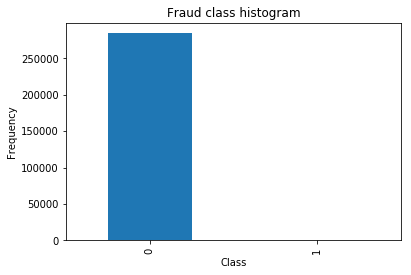

In [9]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [10]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

## 1. Run with Normalising data

In [11]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [12]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [13]:
# Normalising the training data and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [14]:
# Fit classifier to a model
classifier = RandomForestClassifier()
classifier.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_normalized)

In [16]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85298,    11],
       [   29,   105]])

In [17]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85309
          1       0.91      0.78      0.84       134

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999532
Area under the curve : 0.891727


## 2. Run with Over Sampling data using SMOTE (Synthetic Minority Over-sampling Technique)

In [18]:
data2 = pd.read_csv("creditcard.csv")

In [19]:
from sklearn.preprocessing import StandardScaler

data2['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data2 = data2.drop(['Time','Amount'],axis=1)
data2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.338916
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.349231
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.344234
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.233327
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.317487


In [20]:
X = np.array(data.ix[:, data.columns != 'Class'])
y = np.array(data.ix[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 30)
Shape of y: (284807, 1)


In [21]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [22]:
# Over Sampling data using SMOTE
smote = SMOTE(random_state=2)
X_train_resample, y_train_resample = smote.fit_sample(X_train, y_train.ravel())

In [23]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resample, y_train_resample.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [25]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85288,    21],
       [   22,   112]])

In [26]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85309
          1       0.84      0.84      0.84       134

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999497
Area under the curve : 0.917787


## 3. Run with Generative Adversarial Networks (GANs)

In [66]:
data = pd.read_csv("creditcard.csv")
data.drop(['Time'], axis = 1, inplace = True)
data.drop(['Class'], axis = 1, inplace = True)

In [67]:
# Convert data frame to a numpy array
data = np.array(data)
data

array([[ -1.35980713e+00,  -7.27811733e-02,   2.53634674e+00, ...,
          1.33558377e-01,  -2.10530535e-02,   1.49620000e+02],
       [  1.19185711e+00,   2.66150712e-01,   1.66480113e-01, ...,
         -8.98309914e-03,   1.47241692e-02,   2.69000000e+00],
       [ -1.35835406e+00,  -1.34016307e+00,   1.77320934e+00, ...,
         -5.53527940e-02,  -5.97518406e-02,   3.78660000e+02],
       ..., 
       [  1.91956501e+00,  -3.01253846e-01,  -3.24963981e+00, ...,
          4.45477214e-03,  -2.65608286e-02,   6.78800000e+01],
       [ -2.40440050e-01,   5.30482513e-01,   7.02510230e-01, ...,
          1.08820735e-01,   1.04532821e-01,   1.00000000e+01],
       [ -5.33412522e-01,  -1.89733337e-01,   7.03337367e-01, ...,
         -2.41530880e-03,   1.36489143e-02,   2.17000000e+02]])

In [68]:
# Convert array to PyTorch tensor
data = torch.FloatTensor(data)
data.size()

torch.Size([284807, 29])

In [69]:
# Generator's paragrams
g_input_size = 1     # Random noise dimension
g_hidden_size = 50   # Generator complexity
g_output_size = 1   
g_learning_rate = 2e-4
g_steps = 1

#Discriminator's paragrams
d_input_size = 29   # Minibatch size
d_hidden_size = 50  # Discriminator complexity
d_output_size = 1   # Single dimension for 'real' vs. 'fake'
d_learning_rate = 2e-4
d_steps = 1 

minibatch_size = d_input_size

optim_betas = (0.9, 0.999)
num_epochs = 10000
print_interval = 100

In [70]:
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
print("Using data [%s]" % (name))

Using data [Raw data]


In [71]:
def inject_fake_data():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator.


In [72]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [73]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [74]:
def extract(v):
    return v.data.storage().tolist()

In [75]:
def stats(d):
    return [np.mean(d), np.std(d)]

In [76]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [77]:
d_sampler = data[0]
gi_sampler = inject_fake_data()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [78]:
# Training loop alternates between two modes
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        
        D.zero_grad()

        #  1A: Train Discriminator on real data
        d_real_data = Variable(d_sampler)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train Discriminator on fake data
        #d_gen_input = Variable(gi_sampler(minibatch_size, 29))
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
    for g_index in range(g_steps):
        # 2. Train Generator on Discriminator's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    if epoch % print_interval == 0:
        print("%s: Discriminator: Real Error %s / Fake Error %s Generator: %s (Real Data: %s, Fake Data: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



0: Discriminator: Real Error 3.833092212677002 / Fake Error 0.7207157015800476 Generator: 0.6704715490341187 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.77009229618927533, 0.010418597518074552]) 
100: Discriminator: Real Error 0.012722495943307877 / Fake Error 0.6362389922142029 Generator: 0.7652853727340698 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.1233433076533778, 0.043317953254956791]) 
200: Discriminator: Real Error 0.0029825896490365267 / Fake Error 0.33752819895744324 Generator: 1.2314261198043823 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.5389342133341164, 0.052230644849638644]) 
300: Discriminator: Real Error 0.0016122934175655246 / Fake Error 0.37734341621398926 Generator: 1.1741148233413696 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.78959056221205615, 0.0088001136506832729]) 
400: Discriminator: Real Error 0.0007715817191638052 / Fake Error 0.49469202756881714 Generator: 0.9

3600: Discriminator: Real Error 2.741816388152074e-06 / Fake Error 0.0017946885200217366 Generator: 7.316278457641602 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.017344580642108261, 0.45345038103824986]) 
3700: Discriminator: Real Error 2.6226068712276174e-06 / Fake Error 0.0007078509661369026 Generator: 5.4080810546875 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.074466776488156153, 0.61751957942973201]) 
3800: Discriminator: Real Error 2.5033971269294852e-06 / Fake Error 0.00216255453415215 Generator: 6.848730564117432 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.10724848174843295, 0.60871543193435029]) 
3900: Discriminator: Real Error 2.3841876100050285e-06 / Fake Error 0.0003922205651178956 Generator: 7.937126159667969 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.040512378873496221, 0.71882939571231375]) 
4000: Discriminator: Real Error 2.3841876100050285e-06 / Fake Error 0.00103755551390

7200: Discriminator: Real Error 7.152549983402423e-07 / Fake Error 1.302605596720241e-05 Generator: 9.858447074890137 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.16196210271325603, 1.3244442547465887]) 
7300: Discriminator: Real Error 7.152549983402423e-07 / Fake Error 3.458567152847536e-05 Generator: 9.339343070983887 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.027534751542683304, 1.1766731212974155]) 
7400: Discriminator: Real Error 5.960456519460422e-07 / Fake Error 3.055011620745063e-05 Generator: 11.283622741699219 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.33958548564335395, 1.2708019178914651]) 
7500: Discriminator: Real Error 5.960456519460422e-07 / Fake Error 4.815722786588594e-05 Generator: 10.184962272644043 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.049700605972059844, 1.4440520266404164]) 
7600: Discriminator: Real Error 5.960456519460422e-07 / Fake Error 3.075650238315575e